#Algoritimo Genético MultiObjetivo para Imputação Múltipla de Dados Aplicado na Classificação Multirrótulo 

#Importações


In [2]:
import numpy as np
import scipy as sp
import future as ft
import sklearn
from scipy.io import arff
import pandas as pd

#instalações
!pip install scikit-multilearn
!pip install liac-arff # for loading ARFF files
!pip install iterative-stratification 
!pip install missingpy


#importações poś-intalações
from skmultilearn.dataset import load_dataset
import arff


     |████████████████████████████████| 89 kB 4.8 MB/s 
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=af9226353b9cb67c43822ba732621b22294cd6e43a1b1e47ecc32dbe8d5aedbf
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built liac-arff
     |████████████████████████████████| 49 kB 4.0 MB/s 


#Lendo datasets originais do Repositório Mulan





In [ ]:
def load_dataset(dataset_name):
  from skmultilearn.dataset import load_dataset
  X,y,feature_names, label_names = load_dataset(dataset_name, 'undivided')
  return X.toarray(),y.toarray(),feature_names, label_names

In [ ]:
##ordem dos dados (X,y,features e labels)
#data = load_dataset('emotions')

utilizando os dados originais (uploaded)

In [ ]:
def dataset_emotions():
  from scipy.io.arff import loadarff
  raw_data = loadarff('/content/drive/MyDrive/Colab Notebooks/datasets/emotions.arff')
  df = pd.DataFrame(raw_data[0])
  df["amazed-suprised"] = pd.to_numeric(df["amazed-suprised"])
  df["happy-pleased"] = pd.to_numeric(df["happy-pleased"])
  df["relaxing-calm"] = pd.to_numeric(df["relaxing-calm"])
  df["quiet-still"] = pd.to_numeric(df["quiet-still"])
  df["sad-lonely"] = pd.to_numeric(df["sad-lonely"])
  df["angry-aggresive"] = pd.to_numeric(df["angry-aggresive"])
  labels = ['amazed-suprised','happy-pleased','relaxing-calm','quiet-still','sad-lonely','angry-aggresive']
  #dividindo dataset (features e labels)
  feats_df = df.drop(columns = labels).values
  labels_df = df[labels].values
  return df,feats_df,labels_df

In [ ]:
d = dataset_emotions()

In [ ]:
d[2]

array([[0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 1, 1, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [ ]:
def counter(y):
  from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
  from collections import Counter
  distribuicao_labels = Counter(combination for row in get_combination_wise_output_matrix(y, order=1) for combination in row)
  return distribuicao_labels


In [ ]:
counter(d[2])

Counter({(0,): 173, (1,): 166, (2,): 264, (3,): 148, (4,): 168, (5,): 189})




## Aplicando Validação Cruzada k-fold 
Testes iniciais com 10-folds

In [ ]:
#X,y in numpy format
def cross_validation(X,y,num_folds, randon_state=0):
  from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
  mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)
  for train_index, test_index in mskf.split(X, y):
   #print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
  return X_train, X_test, y_train, y_test

In [ ]:
data_train_and_test = cross_validation(d[1], d[2],10)

In [ ]:
X_train = data_train_and_test[0]
X_test = data_train_and_test[1]
y_train = data_train_and_test[2]
y_test = data_train_and_test[3]

#Exibindo informações do dataset trabalhado

In [ ]:
#verificando a presença de valores ausentes
def missing_values(df):
  amount = (df.isna().sum()).sum()
  return amount



In [ ]:
valores_ausentes = missing_values(pd.DataFrame(X_train))
valores_ausentes

0

In [ ]:
#padronização Dataset de teste
#X in numpy format
def padronizacao(X):
  from sklearn.preprocessing import StandardScaler
  scl = StandardScaler()
  X_scaler = scl.fit_transform(X)
  return X_scaler



In [ ]:
X_test_s = padronizacao(X_test)
X_test_s

array([[-0.52751657, -0.7163883 ,  1.21315006, ..., -0.04586578,
        -0.22651953, -0.60392646],
       [-0.15986713, -0.37935696, -0.83883174, ...,  1.14280483,
         0.3797663 ,  0.38762244],
       [ 2.04640878,  1.25442176,  1.24451415, ..., -1.00563697,
        -0.19717983, -0.87608304],
       ...,
       [-0.96235614, -1.02193939, -0.6029958 , ..., -0.76221794,
        -0.88382307, -0.78601863],
       [ 1.4356929 ,  0.61769484,  1.20874808, ...,  0.29080106,
         1.34725769,  0.49765303],
       [-0.89368062, -1.08026503, -0.36782015, ..., -0.88947997,
         0.12370162, -0.67435006]])

#Amputando dataset

*   Mecanismo VA: MCAR



Quantificando os percentuais de valores ausentes de acordo com cada database

In [ ]:
#retorna um lista com as posições com Valores ausentes e o dataset amputado
def amputation(rate, X):
  from numpy import random

  amount_missing_values = int(X.size * rate)
  print('Total dados: '+str(X.size)+'\n Total VAs: '+str(amount_missing_values)+'\n')

  rows = X.shape[0]
  cols = X.shape[1]
  index_list = []
  df = pd.DataFrame(X)

  while(len(index_list)<amount_missing_values):
    a = 0
    b = 0
    row = random.randint(0,rows)
    col = random.randint(0,cols)
    if(a != row and b != col):
      a = row
      b = col
      df.iloc[row,col] = np.nan
      index_list.append([row,col])
  return df, index_list

In [ ]:
a = amputation(0.25, X_train)


Total dados: 38160
 Total VAs: 9540



In [ ]:
a[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,0.672063,0.783788,0.766640,0.458712,0.530384,0.812429,0.028851,0.129039,0.039614,5.762173,1.636819,1.170034,1.051511,0.764163,0.642705,0.617868,0.510265,0.566213,0.509149,0.477275,0.505073,0.463535,0.013519,0.050591,0.009025,8.156257,1.077167,0.624711,0.810244,0.399568,0.279947,0.314215,0.231439,0.345401,0.285389,0.210613,0.321896,0.290551,0.022774,0.095801,0.015057,4.748694,0.536378,0.296306,0.273210,0.175800,0.105508,0.168246,0.115849,0.136020,0.110514,0.100517,0.118630,0.094923,0.051035,68.0,0.014937,136.0,2.0,0.245457,0.105065,0.405399
1,0.081374,0.272747,NaN,NaN,NaN,NaN,0.163038,0.620251,0.458514,0.041426,0.308287,0.538152,0.594871,0.734332,NaN,0.761508,0.066288,0.262370,0.034438,3.480874,1.596532,0.943803,NaN,0.511229,NaN,NaN,NaN,NaN,NaN,0.445187,0.415994,0.405593,0.013621,0.073041,0.010094,1.243981,0.829790,0.252972,0.347831,NaN,0.168601,NaN,NaN,0.178703,0.146937,0.125580,0.128202,NaN,0.020028,0.066940,0.029483,3.963534,0.382360,0.168389,0.117525,0.098341,0.087046,0.057991,0.059393,0.059457,0.053439,0.067684,NaN,0.041565,0.295031,NaN,0.276366,NaN,2.0,0.343547,NaN,0.710924
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,NaN,0.644336,0.441556,0.335964,NaN,0.158538,0.082743,NaN,0.035970,NaN,NaN,0.864034,0.909222,0.780572,NaN,0.639740,NaN,0.526312,0.562622,NaN,0.492292,0.455562,NaN,0.070433,0.008525,NaN,0.592634,0.761852,0.568740,NaN,NaN,NaN,NaN,0.227320,0.296224,0.273855,0.191804,0.198025,0.038119,0.065427,0.029622,3.371796,0.430373,0.172862,0.177523,0.184333,0.095718,0.139323,0.109279,0.090650,0.117886,0.100852,0.079917,0.085821,0.161574,61.0,NaN,183.0,3.0,0.188693,0.045941,0.457372
3,0.042481,NaN,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,NaN,0.809644,0.460945,NaN,0.680122,NaN,0.481380,0.621956,0.049939,NaN,NaN,6.719538,1.377811,1.265771,0.986178,0.710955,0.706904,0.710147,0.688825,0.699573,0.577976,NaN,0.501818,NaN,0.020749,0.106318,NaN,3.992357,0.656429,0.927692,0.569916,0.378919,0.530714,NaN,0.308447,NaN,0.263444,0.359477,0.274257,NaN,0.032678,0.119480,0.028707,4.125111,0.461304,0.280751,NaN,0.142805,NaN,NaN,0.155513,0.167114,NaN,NaN,0.129145,0.122330,NaN,66.0,0.206562,132.0,2.0,0.102839,0.241934,0.351009
4,0.074550,0.140880,0.079789,-93.697749,5.543229,NaN,0.899152,0.890336,0.702328,0.490685,0.796904,0.745373,0.911234,0.594429,0.454186,0.384836,0.035751,0.085592,0.029413,NaN,1.116290,0.926772,0.634988,0.639660,0.552653,NaN,0.584705,0.696173,0.648611,0.689096,NaN,0.578063,NaN,0.136984,NaN,NaN,1.592642,1.027190,0.591399,NaN,0.524420,0.554501,0.606200,0.616760,0.596926,0.524291,0.637971,NaN,0.036151,0.087741,0.030180,5.085385,0.551937,0.257562,0.159950,NaN,0.150907,0.142092,NaN,0.329188,0.251668,0.265049,0.284196,0.189988,0.029308,100.0,0.144039,200.0,2.0,0.195196,0.310801,0.683817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.027142,NaN,NaN,-79.881347,8.119313,1.927310,NaN,0.397888,0.857559,0.302742,0.672649,0.748163,NaN,0.852625,0.597127,0.456126,0.013099,0.029163,0.030049,3.076905,0.862406,0.640101,0.615202,0.557800,0.514684,NaN,0.600797,0.544352,NaN,0.553717,0.493653,NaN,0.012848,0.044107,0.008805,2.560837,NaN,NaN,0.802130,0.694118,0.412457,0.461475,0.500786,0.492573,NaN,0.437815,0.345676,0.366906,0.028604,0.069883,NaN,5.042254,NaN,0.177015,NaN,0.124718,0.118118,0.194543,0.146845,0.139167,0.161785,NaN,0.129552,NaN,0.089991,87.0,0.564842,174.0,2.0,NaN,0.002657,1.149211
526,0.094829,0.204498,0.082824,-61.364436,2.9662

In [ ]:
total_nan = (a[0].isnull().sum()).sum()
total_nan

8492

In [ ]:
def grafic_bar_missing_values(df):
  import missingno as msno
  msno.bar(df)

In [ ]:
def grafic_matrix_missing_values(df):
  import missingno as msno
  msno.matrix(df)

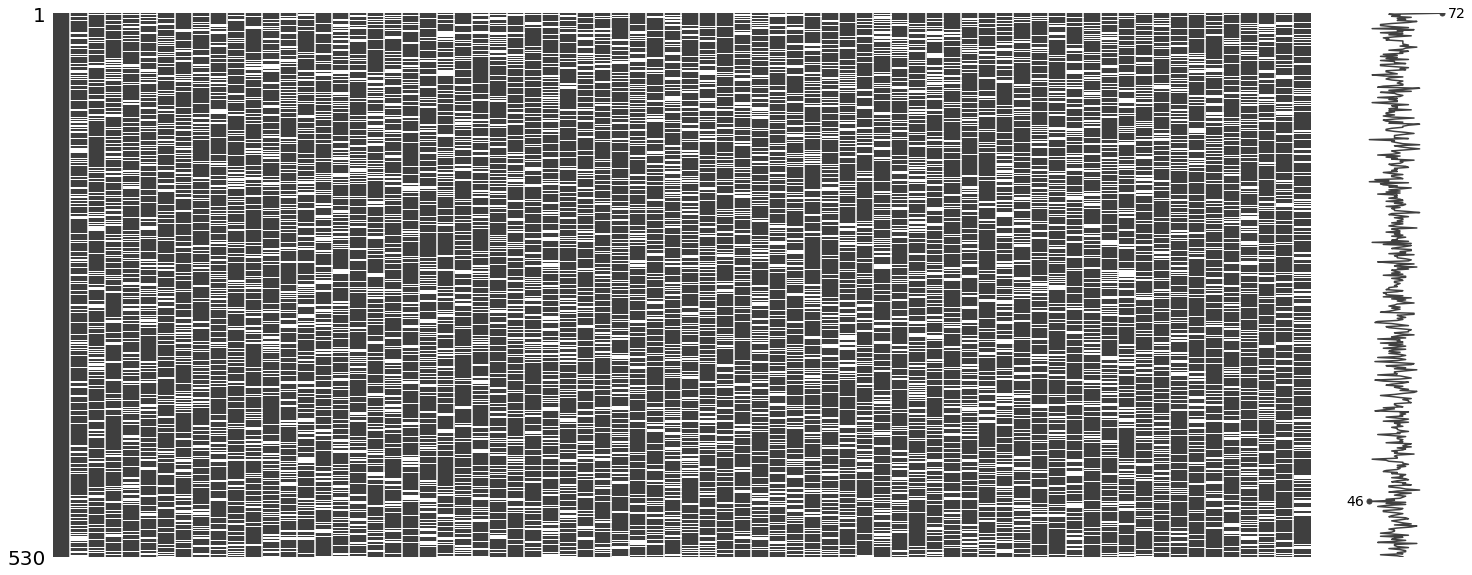

In [ ]:
grafic_matrix_missing_values(pd.DataFrame(a[0]))

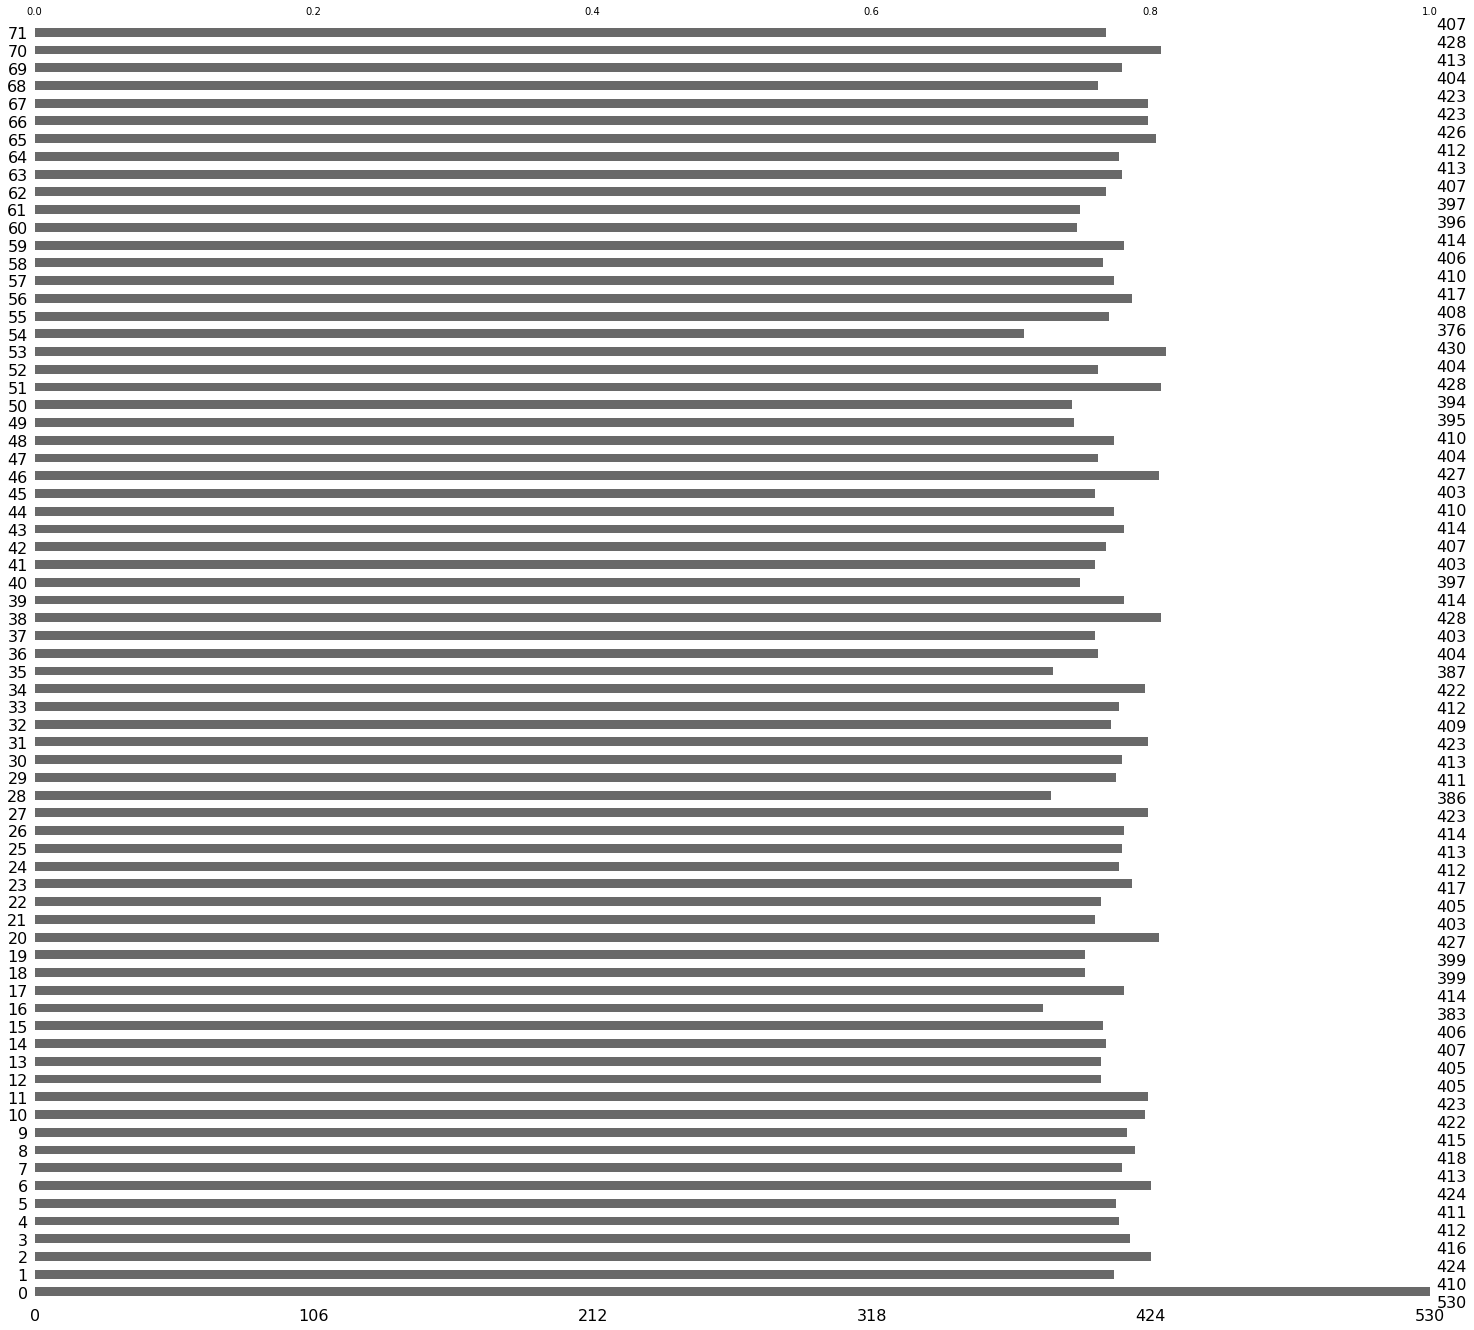

In [ ]:
grafic_bar_missing_values(pd.DataFrame(a[0]))

In [ ]:
def grafic_line_missing_values(df):
  import matplotlib.pyplot as plt 
  plt.figure(figsize=(20,3))
  plt.plot(df.isnull().sum(),marker='o')
  plt.title("Distribuição de Missing Values por features")
  plt.show()

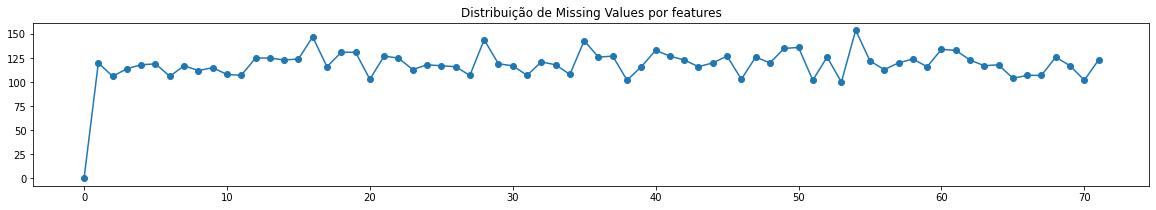

In [ ]:
grafic_line_missing_values(pd.DataFrame(a[0]))

In [ ]:
def describe(df):
  return df.describe()

In [ ]:
describe(pd.DataFrame(d[0]))

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,Mean_Acc1298_Mean_Mem40_MFCC_7,Mean_Acc1298_Mean_Mem40_MFCC_8,Mean_Acc1298_Mean_Mem40_MFCC_9,Mean_Acc1298_Mean_Mem40_MFCC_10,Mean_Acc1298_Mean_Mem40_MFCC_11,Mean_Acc1298_Mean_Mem40_MFCC_12,Mean_Acc1298_Std_Mem40_Centroid,Mean_Acc1298_Std_Mem40_Rolloff,Mean_Acc1298_Std_Mem40_Flux,Mean_Acc1298_Std_Mem40_MFCC_0,Mean_Acc1298_Std_Mem40_MFCC_1,Mean_Acc1298_Std_Mem40_MFCC_2,Mean_Acc1298_Std_Mem40_MFCC_3,Mean_Acc1298_Std_Mem40_MFCC_4,Mean_Acc1298_Std_Mem40_MFCC_5,Mean_Acc1298_Std_Mem40_MFCC_6,Mean_Acc1298_Std_Mem40_MFCC_7,Mean_Acc1298_Std_Mem40_MFCC_8,Mean_Acc1298_Std_Mem40_MFCC_9,Mean_Acc1298_Std_Mem40_MFCC_10,Mean_Acc1298_Std_Mem40_MFCC_11,Mean_Acc1298_Std_Mem40_MFCC_12,Std_Acc1298_Mean_Mem40_Centroid,Std_Acc1298_Mean_Mem40_Rolloff,Std_Acc1298_Mean_Mem40_Flux,Std_Acc1298_Mean_Mem40_MFCC_0,Std_Acc1298_Mean_Mem40_MFCC_1,Std_Acc1298_Mean_Mem40_MFCC_2,Std_Acc1298_Mean_Mem40_MFCC_3,Std_Acc1298_Mean_Mem40_MFCC_4,Std_Acc1298_Mean_Mem40_MFCC_5,Std_Acc1298_Mean_Mem40_MFCC_6,Std_Acc1298_Mean_Mem40_MFCC_7,Std_Acc1298_Mean_Mem40_MFCC_8,Std_Acc1298_Mean_Mem40_MFCC_9,Std_Acc1298_Mean_Mem40_MFCC_10,Std_Acc1298_Mean_Mem40_MFCC_11,Std_Acc1298_Mean_Mem40_MFCC_12,Std_Acc1298_Std_Mem40_Centroid,Std_Acc1298_Std_Mem40_Rolloff,Std_Acc1298_Std_Mem40_Flux,Std_Acc1298_Std_Mem40_MFCC_0,Std_Acc1298_Std_Mem40_MFCC_1,Std_Acc1298_Std_Mem40_MFCC_2,Std_Acc1298_Std_Mem40_MFCC_3,Std_Acc1298_Std_Mem40_MFCC_4,Std_Acc1298_Std_Mem40_MFCC_5,Std_Acc1298_Std_Mem40_MFCC_6,Std_Acc1298_Std_Mem40_MFCC_7,Std_Acc1298_Std_Mem40_MFCC_8,Std_Acc1298_Std_Mem40_MFCC_9,Std_Acc1298_Std_Mem40_MFCC_10,Std_Acc1298_Std_Mem40_MFCC_11,Std_Acc1298_Std_Mem40_MFCC_12,BH_LowPeakAmp,BH_LowPeakBPM,BH_HighPeakAmp,BH_HighPeakBPM,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.069309,0.195399,0.085695,-72.998228,4.979178,0.602395,1.694625,0.634156,0.833964,0.508060,0.539452,0.471183,0.509122,0.477661,0.439237,0.445350,0.045755,0.157495,0.035775,4.574782,1.298807,0.941415,0.778116,0.650144,0.577431,0.552497,0.536358,0.518485,0.509343,0.492222,0.483663,0.469662,0.023932,0.063271,0.008137,3.641956,0.858002,0.623887,0.499193,0.385509,0.331884,0.313391,0.307803,0.304763,0.298987,0.287374,0.279034,0.271922,0.028901,0.066452,0.029527,4.147196,0.408222,0.239404,0.198588,0.151062,0.123111,0.115476,0.114181,0.113154,0.113794,0.109990,0.109876,0.107114,0.230008,74.456998,0.247854,155.215852,2.099494,0.412940,0.354901,0.959906,0.291737,0.279933,0.445194,0.249578,0.283305,0.318718
std,0.031293,0.117605,0.009260,7.580804,2.071792,1.017603,0.606581,0.448746,0.368312,0.303277,0.304705,0.282673,0.244190,0.219967,0.221101,0.201583,0.029710,0.108850,0.008561,1.560977,0.403095,0.270601,0.213410,0.154363,0.107429,0.094156,0.090469,0.083432,0.081292,0.072786,0.074544,0.077775,0.010763,0.031272

In [ ]:
#Instalando o panda profile
#!pip install pandas-profiling
#from pandas_profiling import ProfileReport

#Imputação de dados


*   k-Nearest Neighbors (kNN) Imputation
*   mean
*   most_frequent
*   median







# Criação da popoulação inicial

imputando os indivíduos

In [ ]:
#def knnImp(dataset_amputed):
#  from missingpy import KNNImputer
#  imputer_knn = KNNImputer(missing_values="NaN", n_neighbors=5, weights="uniform", 
#                 metric="masked_euclidean", row_max_missing=0.5, 
#                 col_max_missing=0.8, copy=True)
  
  #X_imputed_KNNI = imputer_knn.fit_transform(dataset_amputed)
  #return X_imputed_KNNI

In [ ]:
from sklearn.impute import KNNImputer
def knnImp(dataset_amputed,neighbors):
  inputer_knn = KNNImputer(n_neighbors=neighbors)
  X_imputed_knn = inputer_knn.fit_transform(dataset_amputed)
  return X_imputed_knn

In [ ]:
def rfImp(dataset_amputed):
  from missingpy import MissForest
  imputer_RFI = MissForest()
  X_imputed_RFI = imputer_RFI.fit_transform(dataset_amputed)
  return X_imputed_RFI

In [ ]:
def meanImp(dataset_amputed):
  from sklearn.impute import SimpleImputer
  imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  imputer_mean=imputer_mean.fit(dataset_amputed)
  X_imputed_mean = imputer_mean.transform(dataset_amputed)
  return X_imputed_mean

In [ ]:
def mostFrequentImp(dataset_amputed):
  from sklearn.impute import SimpleImputer
  imputer_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  imputer_most_frequent=imputer_most_frequent.fit(dataset_amputed)
  X_imputed_most_frequent=imputer_most_frequent.transform(dataset_amputed)
  return X_imputed_most_frequent

In [ ]:
def medianImp(dataset_amputed):
  from sklearn.impute import SimpleImputer
  imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
  imputer_median=imputer_median.fit(dataset_amputed)
  X_imputed_median=imputer_median.transform(dataset_amputed)
  return X_imputed_median

In [ ]:
def imputation(method, df):
  #import gerais
  import sklearn.neighbors._base
  import sys
  sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
  

  if method == 'mean':
    base_imputada = meanImp(df)
  elif method == 'median':
    base_imputada = medianImp(df)
  elif method == 'most_frequent':
    base_imputada = mostFrequentImp(df)
  elif method == 'knn-3':
    base_imputada = knnImp(df,3)
  elif method == 'knn-5':
    base_imputada = knnImp(df,5)
  elif method == 'knn-10':
    base_imputada = knnImp(df,10)
  return base_imputada


Padronização dos dados

In [ ]:
imputation_meth  = ['knn-3','knn-5','knn-10', 'mean', 'most_frequent', 'median']
inds = []
df_amp = pd.DataFrame(a[0])
for i  in imputation_meth:
  inds.append(imputation(i,df_amp))

In [ ]:
inds

[array([[0.034741  , 0.089665  , 0.091225  , ..., 0.245457  , 0.105065  ,
         0.405399  ],
        [0.081374  , 0.272747  , 0.08062733, ..., 0.343547  , 0.275818  ,
         0.710924  ],
        [0.110545  , 0.273567  , 0.08441   , ..., 0.188693  , 0.045941  ,
         0.457372  ],
        ...,
        [0.035169  , 0.065403  , 0.075227  , ..., 0.163959  , 0.247136  ,
         0.350805  ],
        [0.054276  , 0.190657  , 0.095935  , ..., 0.547126  , 0.22484433,
         1.25582   ],
        [0.073194  , 0.10244633, 0.080545  , ..., 0.087328  , 0.236815  ,
         0.451701  ]]),
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0843284, ..., 0.343547 , 0.2718072,
         0.710924 ],
        [0.110545 , 0.273567 , 0.08441  , ..., 0.188693 , 0.045941 ,
         0.457372 ],
        ...,
        [0.035169 , 0.065403 , 0.075227 , ..., 0.1825452, 0.247136 ,
         0.7359386],
        [0.054276 , 0.2024876, 0.095

In [ ]:
len(inds)

6

Normmalização da população inicial

In [ ]:
populationInitial = inds
#for i in range(len(populationInitial)):
#  populationInitial.append(padronizacao(populationInitial[i]))

In [ ]:
len(populationInitial)

6

In [ ]:
inds[0].shape, populationInitial[0].shape

((530, 72), (530, 72))

In [ ]:
X_train.shape, y_train.shape

((530, 72), (530, 6))

In [ ]:
for i in y_test:
  print(i)

[0 1 1 0 0 0]
[1 1 0 0 0 0]
[0 0 0 0 0 1]
[1 0 0 0 0 1]
[1 1 0 0 0 0]
[0 0 1 1 0 0]
[0 0 1 0 0 0]
[0 1 1 0 0 0]
[1 0 0 0 0 0]
[0 0 1 1 0 0]
[0 0 1 1 1 0]
[0 0 0 0 0 1]
[0 0 0 0 0 1]
[0 0 1 0 1 0]
[0 0 1 1 1 0]
[0 0 0 1 1 0]
[0 0 1 1 0 0]
[1 0 0 0 0 1]
[0 1 0 0 0 0]
[1 0 0 0 0 0]
[0 0 0 0 0 1]
[0 0 0 0 0 1]
[0 1 1 0 0 0]
[0 0 0 0 0 1]
[0 0 0 0 0 1]
[1 0 0 0 0 1]
[1 0 0 0 0 0]
[0 0 0 0 0 1]
[1 1 0 0 0 0]
[0 0 0 0 0 1]
[0 0 1 1 1 0]
[0 0 0 0 0 1]
[1 1 0 0 0 0]
[0 0 1 1 0 0]
[0 1 1 0 0 0]
[1 1 0 0 0 0]
[1 0 0 0 0 1]
[0 0 0 0 0 1]
[0 0 1 0 1 0]
[0 1 1 0 0 0]
[0 0 1 0 0 0]
[1 0 0 0 0 0]
[0 1 1 0 0 0]
[0 0 0 1 1 1]
[0 0 0 0 1 0]
[0 1 1 0 0 0]
[0 0 1 1 1 0]
[1 0 0 0 0 1]
[1 0 0 0 1 0]
[0 0 0 0 0 1]
[1 1 0 0 0 0]
[0 0 1 1 1 0]
[0 1 1 0 0 0]
[1 1 0 0 0 0]
[0 0 1 0 0 0]
[0 0 0 1 1 0]
[0 0 1 0 1 0]
[1 0 0 0 1 0]
[0 0 1 1 1 0]
[0 0 0 1 1 0]
[0 0 1 0 0 0]
[0 0 1 0 0 0]
[0 0 0 1 1 0]


In [ ]:
np.unique(y_test)

array([0, 1])

# Função Fitness

Os indivíduos da população são avaliados no aprendizado multirrótulo.
Neste experimento, serão testados algorítmos que transformam o problema e algorítmos que adaptam o problema.

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def evaluation_BinaryRelevance(core_algorithm, individual):
  p = []
  if core_algorithm == 'svm':
    classifier_br = BinaryRelevance(classifier=SVC(C=50),require_dense=[False, True])#
    classifier_br.fit(individual, y_train)
    prediction_br = classifier_br.predict(X_test)

    F1 = f1_score(y_test, prediction_br, average='micro')
    ACC = accuracy_score(y_test, prediction_br)
    HL = hamming_loss(y_test, prediction_br)

  elif core_algorithm == 'randomForest':
    classifier = BinaryRelevance(classifier = RandomForestClassifier(),require_dense = [False, True])
    classifier.fit(individual, y_train)
    prediction_br_RFC=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_RFC, average='micro')
    ACC = accuracy_score(y_test, prediction_br_RFC)
    HL = hamming_loss(y_test, prediction_br_RFC)
  elif core_algorithm == '3nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=3))
    classifier.fit(individual, y_train)
    prediction_br_3knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_3knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_3knn)
    HL = hamming_loss(y_test, prediction_br_3knn)
  elif core_algorithm == '5nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier())
    classifier.fit(individual, y_train)
    prediction_br_5knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_5knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_5knn)
    HL = hamming_loss(y_test, prediction_br_5knn)
  elif core_algorithm == '10nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=10))
    classifier.fit(individual, y_train)
    prediction_br_10knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_10knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_10knn)
    HL = hamming_loss(y_test, prediction_br_10knn) 
  elif core_algorithm == 'lr':
    from sklearn.linear_model import LogisticRegression
    classifier = BinaryRelevance(classifier = LogisticRegression())
    classifier.fit(individual, y_train)
    prediction_br_lr=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_lr, average='micro')
    ACC = accuracy_score(y_test, prediction_br_lr)
    HL = hamming_loss(y_test, prediction_br_lr)
  return ACC,F1,HL

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#Exact Match
def acc_multi(y_true, y_pred):
  class_accuracies = []
  for class_ in np.unique(y_true):
    #print('classe:', class_)
    #print('y_pred[y_true == class_]: ',y_pred[y_true == class_])
    #print('y_pred[y_true == class_] == class_: ',y_pred[y_true == class_] == class_)
    class_acc = np.mean(y_pred[y_true == class_] == class_)
    #print('class_acc:',class_acc)
    class_accuracies.append(class_acc)
    #print('------------------------------')
  #for i in class_accuracies:
    #print(i)
    
  return np.mean(class_accuracies)

def example_based_accuracy(y_true, y_pred):
    
    # compute true positives using the logical AND operator
    numerator = np.sum(np.logical_and(y_true, y_pred), axis = 1)

    # compute true_positive + false negatives + false positive using the logical OR operator
    denominator = np.sum(np.logical_or(y_true, y_pred), axis = 1)
    instance_accuracy = numerator/denominator

    avg_accuracy = np.mean(instance_accuracy)
    return avg_accuracy

#ex_based_accuracy = example_based_accuracy(y_true, y_pred)
#print(f"Example Based Accuracy: {ex_based_accuracy}")

def evaluation_multirrotulo(core_algorithm, individual):
  p = []
  if core_algorithm == 'svm':
    classifier_br = BinaryRelevance(classifier=SVC(C=50),require_dense=[False, True])#
    classifier_br.fit(individual, y_train)
    prediction_br = classifier_br.predict(X_test)


    F1 = f1_score(y_test, prediction_br, average='micro')
    #ACC2 = example_based_accuracy(y_test, prediction_br)
    EM = accuracy_score(y_test, prediction_br) #EM in multi é equivante a ACC em binário Classifier
    ACC = acc_multi(y_test, prediction_br)
    HL = hamming_loss(y_test, prediction_br)
    #print('ACC = ', EM)

  elif core_algorithm == 'randomForest':
    classifier = BinaryRelevance(classifier = RandomForestClassifier(),require_dense = [False, True])
    classifier.fit(individual, y_train)
    prediction_br_RFC=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_RFC, average='micro')
    EM = accuracy_score(y_test, prediction_br_RFC)
    HL = hamming_loss(y_test, prediction_br_RFC)
    ACC = acc_multi(y_test, prediction_br_RFC)

  elif core_algorithm == '3nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=3))
    classifier.fit(individual, y_train)
    prediction_br_3knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_3knn, average='micro')
    EM = accuracy_score(y_test, prediction_br_3knn)
    HL = hamming_loss(y_test, prediction_br_3knn)
    ACC = acc_multi(y_test, prediction_br_3knn)
  elif core_algorithm == '5nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier())
    classifier.fit(individual, y_train)
    prediction_br_5knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_5knn, average='micro')
    EM = accuracy_score(y_test, prediction_br_5knn)
    HL = hamming_loss(y_test, prediction_br_5knn)
    ACC = acc_multi(y_test, prediction_br_5knn)
  elif core_algorithm == '10nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=10))
    classifier.fit(individual, y_train)
    prediction_br_10knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_10knn, average='micro')
    EM = accuracy_score(y_test, prediction_br_10knn)
    HL = hamming_loss(y_test, prediction_br_10knn) 
    ACC = acc_multi(y_test, prediction_br_10knn)
  elif core_algorithm == 'lr':
    from sklearn.linear_model import LogisticRegression
    classifier = BinaryRelevance(classifier = LogisticRegression())
    classifier.fit(individual, y_train)
    prediction_br_lr=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_lr, average='micro')
    EM = accuracy_score(y_test, prediction_br_lr)
    HL = hamming_loss(y_test, prediction_br_lr)
    ACC = acc_multi(y_test, prediction_br_lr)
  return EM,ACC,HL

In [ ]:
#svm = evaluation_binaryRelevance('svm', populationInitial[0])
#knn3 = evaluation_binaryRelevance('3nn', populationInitial[0])
#knn5 = evaluation_binaryRelevance('5nn', populationInitial[0])
#knn10 = evaluation_binaryRelevance('10nn', populationInitial[0])
#rf = evaluation_binaryRelevance('randomForest', populationInitial[0])


In [ ]:
acc_multi(np.array([[1,1,0],[1,1,0]]),np.array([[0,1,0],[1,1,0]]))
#output
#classe: 0
#y_pred[y_true == class_]:  [0 0]
#y_pred[y_true == class_] == class_:  [ True  True]
#class_acc: 1.0
#------------------------------
#classe: 1
#y_pred[y_true == class_]:  [0 1 1 1]
#y_pred[y_true == class_] == class_:  [False  True  True  True]
#class_acc: 0.75
#------------------------------
#0.875

0.875

In [ ]:
#print(svm, knn3, knn5,knn10, rf)

Não executando Random Forest devido também ser um algorítmo que funciona como bagging

In [ ]:
def fitness_multi(population,base_algoritmo):
  metrica = []
  bests = []
  aval_total_ind = []
  populacao = []
  sort_dsc=[]
  sort_asc=[]
  indivuduos = {}
  accuracy = {}
  #print('tam_pop_atual: ',len(population))
  print('Avaliações com Binary Relevance\n')
  indexx = 0
  for i in range(len(population)):
    #print('Individual - ',i)
    a,f,h = evaluation_BinaryRelevance(base_algoritmo, population[indexx])
    print('ind:['+str(i)+'] - '+str(a)+' '+ str(f)+' '+str(h)+' ['+str(a+f-h)+']' )
    
    #realizando o calculo multiobjetivo: sum = acc+f1-hl
    sum = a+f-h
    metrica.append([sum,a,f,h])

    #sort_dsc = sorted(metrica, reverse=True)
    #sort_asc = sorted(metrica)
    #print(sort)
    #melhor = sort_dsc[0]
    #pior = sort_asc[0]
    #print(str(melhor))
    #print(str(pior))
    populacao.append([[sum,a,f,h], population[indexx]])
    indexx = indexx+1
    #aval_total_ind.append(sum)
    #metrica = []
    sort_dsc=[]
    sort_asc=[]
    melhor =''
    pior=''
  return sorted(populacao, key=lambda x: x[0][0], reverse=True)#sorted(populacao,reverse=True)

In [ ]:
def melhor_ind_(populacao,index=0):
  #EM[0][0][0],ACC[0][0][1],HL[0][0][2]
  best = populacao[0]
  #print(best[0][0])
  for ind in populacao:
    next = ind
    #print(next[0][0])
    #break
    if next[0][0]>best[0][0] :
      best = next
    elif next[0][0] == best[0][0]:
      if next[0][1]>best[0][1]:
        best = next
      elif next[0][1] == best[0][1]:
        if next[0][2]<best[0][2]:
          best = next
        else:
          best = best
      else:
        best = best
    print(best[0][0])      
  return best

In [ ]:
def ordenacao_populacao(populacao,index=0):
  best = populacao[index]
  s = []
  if(len(populacao)<2):
    s.append(best)
  else:
    next = populacao[index+1]
    print(best)
    print('-----------------------------')
    print(next)
    print('-----------------------------')
    print(next[0][0])
    print('tamanho da população atual: ', len(populacao))
    print('lista de individuos ordenados: ', len(s))
    if(next[0][0]>best[0][0]):
      print('melhor EM')
      best = next
      s.append(best)
      populacao.pop(index+1)
    elif next[0][0] == best[0][0]:
      if next[0][1]>best[0][1]:
        print('melhor ACC')
        best = next
        s.append(best)
        populacao.pop(index+1)
      elif next[0][1] == best[0][1]:
        if next[0][2]<best[0][2]:
          print('melhor HL')
          best = next
          s.append(best)
          populacao.pop(index+1)
        else:
          print('O atual é o melhror')
          s.append(best)
          populacao.pop(index)
      else:
        print('else ACC')
        s.append(best)
        print('index', index)
        print('removido',populacao.pop(index))
    else:
      print('else EM')
      s.append([best])
      print('index', index)
      populacao.pop(index)
    print(len(s))
    s.append(ordenacao_populacao(populacao, index+1))
    print('tamanho da lista recurs: ', len(s))
  return s

In [ ]:
def fitness_multiObjetivo(population,base_algoritmo):
  sort_pop = []
  metrica = []
  bests = []
  aval_total_ind = []
  populacao = []
  sort_dsc=[]
  sort_asc=[]
  indivuduos = {}
  accuracy = {}
  #print('tam_pop_atual: ',len(population))
  print('Binary Relevance Classification\n')
  indexx = 0
  for i in range(len(population)):
    #print('Individual - ',i)
    E,A,H = evaluation_multirrotulo(base_algoritmo, population[indexx])
    print('ind:['+str(i)+'] - '+str(E)+' '+ str(A)+' '+str(H) )
    
    #realizando o calculo multiobjetivo: sum = acc+f1-hl
    #sum = E+A-H
    metrica.append([E,A,H])
    populacao.append([[E,A,H], population[indexx]])
    indexx = indexx+1
    sort_dsc=[]
    sort_asc=[]
    melhor =''
    pior=''
  #fitness = melhor_ind_(populacao)
  return sorted(populacao, key=lambda x: x[0][0], reverse=True)

In [ ]:
r = fitness_multiObjetivo(populationInitial,'svm')

Binary Relevance Classification

ind:[0] - 0.23809523809523808 0.6632632293080054 0.23809523809523808
ind:[1] - 0.23809523809523808 0.6587177747625509 0.24074074074074073
ind:[2] - 0.20634920634920634 0.6541723202170964 0.24338624338624337
ind:[3] - 0.20634920634920634 0.6362279511533243 0.24603174603174602
ind:[4] - 0.07936507936507936 0.6003392130257802 0.25132275132275134
ind:[5] - 0.20634920634920634 0.6362279511533243 0.24603174603174602


In [ ]:
for i in r:
  print(i[0])

[0.23809523809523808, 0.6632632293080054, 0.23809523809523808]
[0.23809523809523808, 0.6587177747625509, 0.24074074074074073]
[0.20634920634920634, 0.6541723202170964, 0.24338624338624337]
[0.20634920634920634, 0.6362279511533243, 0.24603174603174602]
[0.20634920634920634, 0.6362279511533243, 0.24603174603174602]
[0.07936507936507936, 0.6003392130257802, 0.25132275132275134]


In [ ]:
r[1]

[[0.23809523809523808, 0.6587177747625509, 0.24074074074074073],
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0843284, ..., 0.343547 , 0.2718072,
         0.710924 ],
        [0.110545 , 0.273567 , 0.08441  , ..., 0.188693 , 0.045941 ,
         0.457372 ],
        ...,
        [0.035169 , 0.065403 , 0.075227 , ..., 0.1825452, 0.247136 ,
         0.7359386],
        [0.054276 , 0.2024876, 0.095935 , ..., 0.547126 , 0.187447 ,
         1.25582  ],
        [0.073194 , 0.0902506, 0.080545 , ..., 0.087328 , 0.236815 ,
         0.451701 ]])]

In [ ]:
#populacao_inicial_avaliada = fitness(populationInitial,'ACC')

In [ ]:
#populacao_inicial_avaliada

# Elitismo
O melhor individuo é passado para a proxima geracao - Elitismo

In [ ]:
#def elitismo(populacao_avaliada):
#  #ordena a população passada de forma descrescente
#  populacao_ordenada  = sorted(populacao_avaliada, key=lambda x: x[0], reverse=True)
#  elitista = populacao_ordenada[0]
#  return elitista

In [ ]:
#elitista = elitismo(populacao_inicial_avaliada)

In [ ]:
#elitista

# Seleção

O processo de seleçãp é dado por torneio, sorteando dois pais

In [ ]:
import random
def selecao(pop_atual):
  sorteio1 = random.choice(range(len(pop_atual)))
  #print(sorteio1)
  sorteio2 = random.choice(range(len(pop_atual)))
  #print(sorteio2)
  pai1 = pop_atual[sorteio1]
  pai2 = pop_atual[sorteio2]
  #print('pai 1')
  #print(pai1)
  #print('pai 2')
  #print(pai2)
  #print('pai 2[0]')
  #print(pai2[0][0])
  #print('fimpai 2')
  if(pai1[0][0] >= pai2[0][0]):
    return pai1
  else:
    return pai2

In [ ]:
selecao(r)

[[0.23809523809523808, 0.6632632293080054, 0.23809523809523808],
 array([[0.034741  , 0.089665  , 0.091225  , ..., 0.245457  , 0.105065  ,
         0.405399  ],
        [0.081374  , 0.272747  , 0.08062733, ..., 0.343547  , 0.275818  ,
         0.710924  ],
        [0.110545  , 0.273567  , 0.08441   , ..., 0.188693  , 0.045941  ,
         0.457372  ],
        ...,
        [0.035169  , 0.065403  , 0.075227  , ..., 0.163959  , 0.247136  ,
         0.350805  ],
        [0.054276  , 0.190657  , 0.095935  , ..., 0.547126  , 0.22484433,
         1.25582   ],
        [0.073194  , 0.10244633, 0.080545  , ..., 0.087328  , 0.236815  ,
         0.451701  ]])]

#Cruzamento

Cruzamento de n-points

In [ ]:
#indeces com a posição do valores ausentes
index_vas = a[1]

In [ ]:
index_vas

[[92, 5],
 [298, 68],
 [93, 19],
 [278, 9],
 [33, 45],
 [23, 30],
 [217, 5],
 [34, 7],
 [351, 64],
 [255, 3],
 [44, 14],
 [466, 41],
 [414, 18],
 [398, 52],
 [467, 51],
 [67, 5],
 [43, 55],
 [222, 40],
 [407, 52],
 [472, 45],
 [488, 5],
 [450, 54],
 [327, 52],
 [203, 5],
 [238, 58],
 [301, 60],
 [462, 56],
 [140, 19],
 [260, 14],
 [262, 60],
 [500, 23],
 [280, 48],
 [308, 10],
 [39, 47],
 [36, 32],
 [362, 33],
 [115, 44],
 [142, 35],
 [515, 1],
 [139, 55],
 [463, 49],
 [22, 51],
 [18, 24],
 [103, 49],
 [43, 20],
 [195, 41],
 [289, 41],
 [325, 20],
 [326, 10],
 [314, 31],
 [418, 28],
 [18, 47],
 [436, 66],
 [70, 19],
 [311, 3],
 [521, 52],
 [452, 16],
 [415, 7],
 [23, 25],
 [455, 10],
 [9, 58],
 [223, 55],
 [142, 50],
 [28, 70],
 [133, 30],
 [97, 8],
 [525, 52],
 [138, 19],
 [332, 57],
 [53, 11],
 [126, 39],
 [36, 54],
 [343, 24],
 [458, 21],
 [51, 12],
 [276, 56],
 [213, 27],
 [308, 26],
 [431, 36],
 [145, 40],
 [506, 2],
 [264, 2],
 [214, 32],
 [346, 54],
 [272, 52],
 [407, 27],
 [465

In [ ]:
def crossover(list_index_vas,n_points, new_population, tam_population):
  quantidade_sem_mutacoes = tam_population - int(tam_population*0.8)
  nova_populacao_com_crossover = []
  #adiciona os melhores, com exceção do elitista, na próxima geração
  #o elitista já é passado diretamente para a próxima geração avaliada
  for i in range(1,quantidade_sem_mutacoes):
    melhor = new_population.pop(i)
    #melhores = new_population[1]
    #print('melhor'+str(i)+': '+type(melhor[1]))
    nova_populacao_com_crossover.append(melhor[1])
  while(len(nova_populacao_com_crossover)<int(tam_population)-1):
    sorteio1 = random.choice(range(len(new_population)))
    #escolha dos pais que terão materiais trocados
    #print(sorteio1)
    sorteio2 = random.choice(range(len(new_population)))
    #print(sorteio2)
    #print(len(nova_populacao_com_crossover))
    while(sorteio1 == sorteio2):
      sorteio2 = random.choice(range(len(new_population)))
    pai1 = new_population[sorteio1]
    pai2 = new_population[sorteio2]

    df_pai1 = pd.DataFrame(pai1[1])
    df_pai2 = pd.DataFrame(pai2[1])
  
    genes_all_pai1 = []

    genes_all_pai2 = []

    #recuperando os genes de cada pai
    for i in list_index_vas:
      genes_all_pai1.append(df_pai1.iloc[i[0],i[1]])
      genes_all_pai2.append(df_pai2.iloc[i[0],i[1]])
    #dividindo os genes de acordo com o n_points
    divide_genes_pai_1 = np.array_split(genes_all_pai1,n_points)
    divide_genes_pai_2 = np.array_split(genes_all_pai2,n_points)

    genes_0_pai1 = divide_genes_pai_1[0]
    genes_1_pai1 = divide_genes_pai_1[1]

    genes_0_pai2 = divide_genes_pai_2[0]
    genes_1_pai2 = divide_genes_pai_2[1]

    t1 = len(genes_1_pai1)
    t2 = len(genes_1_pai2)

    divide_list_index = np.array_split(list_index_vas,n_points)
    primeira_parte = divide_list_index[0]
    segunda_parte = divide_list_index[1]

    genes_parte_2_pai1 = genes_1_pai1.tolist()
    genes_parte_2_pai2 = genes_1_pai2.tolist()

    #Trocando genes dos pais
    index = 0
    for i in segunda_parte:
      df_pai1.iloc[i[0].astype(int), i[1].astype(int)] = genes_1_pai2[index]
      df_pai2.iloc[i[0].astype(int), i[1].astype(int)] = genes_1_pai1[index]
      index = index +1
    filho1 = df_pai1
    nova_populacao_com_crossover.append(filho1.to_numpy())

    if(len(nova_populacao_com_crossover)<tam_population):
      filho2 = df_pai2
      nova_populacao_com_crossover.append(filho2.to_numpy())
  #filho1, filho2,pai1[1],pai1[2]
  print('Tamanho da nova população gerada por meio do cruzamento:',len(nova_populacao_com_crossover))
  return nova_populacao_com_crossover

In [ ]:
nova_populacao_recombinada = crossover(index_vas,2,r,10)
#print('tam_pop'+str(len(nova_populacao_recombinada)))
nova_populacao_recombinada

Tamanho da nova população gerada por meio do cruzamento: 9


[array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0843284, ..., 0.343547 , 0.2718072,
         0.710924 ],
        [0.110545 , 0.273567 , 0.08441  , ..., 0.188693 , 0.045941 ,
         0.457372 ],
        ...,
        [0.035169 , 0.065403 , 0.075227 , ..., 0.1825452, 0.247136 ,
         0.7359386],
        [0.054276 , 0.2024876, 0.095935 , ..., 0.547126 , 0.187447 ,
         1.25582  ],
        [0.073194 , 0.0902506, 0.080545 , ..., 0.087328 , 0.236815 ,
         0.451701 ]]),
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0869201, ..., 0.343547 , 0.3081554,
         0.710924 ],
        [0.110545 , 0.273567 , 0.08441  , ..., 0.188693 , 0.045941 ,
         0.457372 ],
        ...,
        [0.035169 , 0.065403 , 0.075227 , ..., 0.2395696, 0.247136 ,
         0.7112323],
        [0.054276 , 0.2188049, 0.095935 , ..., 0.547126 , 0.2673415,
   

# Mutação

In [ ]:
def mutacao(dX_amputed,ind, list_missing_values):
  import random
  #de numpy para pandas format
  ind = pd.DataFrame(ind)
  #serão selecionados x% de individuos da população e são trocadas todas as solucões
  #candidatas já imputadas por uma nova solução da pool de soluções
  #amount_inds_mutation = int(rate_mutation *  len(inds_pop))
  for i in list_missing_values:
    #criando um pool solutions de acordo com a o valor de x da lista de index
    lista_do_indice_atual = dX_amputed.iloc[:,i[1]]
    #removendo o indices NaN para criar a pool solutions só com soluções candatas não-nulas
    pool_solutions = [x for x in lista_do_indice_atual if pd.isnull(x) == False]
    #substituindo o gene do indivíduo por um dos genes da pool solutions
    #print('index: ', i[0],',', i[1])
    #print('antes: ',ind.iloc[i[0],i[1]])
    ind.iloc[i[0],i[1]] = random.choice(pool_solutions)
    #print('depois: ',ind.iloc[i[0],i[1]])
  return ind.to_numpy()

In [ ]:
#ind = mutacao(df_amp)

In [ ]:
def mutations(dX_amputed,population, rate_mutation,list_missing_values):
  populacao_cruzada = population.copy()
  amount_inds_mutation = int(rate_mutation *  len(populacao_cruzada))
  i = 0
  while(i < amount_inds_mutation):
    #o sorteado não pode ser o elitistista
    sorteado = random.choice(range(1,len(population)))
    ind_escolhido_pra_mutacao = populacao_cruzada.pop(sorteado)
    ind_mutado = mutacao(dX_amputed, ind_escolhido_pra_mutacao,list_missing_values)
    populacao_cruzada.append(ind_mutado)   
    i=i+1
  return populacao_cruzada

# Algoritmo Genético



1.   elitisimo: 1
2.   gerações: 6
3.   geracoes_sizes{6,12,18,24,30}
4.   cruzamento: n-points
5.   cruzamento: torneio



In [ ]:
def nova_populacao(df_amp,individuo_elitista, pop_atual, tam_population,n_points, list_index_vas=index_vas):
  formacao_nova_populacao = []
  #formacao_nova_populacao.append(individuo_elitista)
  while(len(formacao_nova_populacao)<= tam_population):
    formacao_nova_populacao.append(selecao(pop_atual))
  #pega a população selecionada para fazer a recombinação
  nova_populacao_combinada = crossover(list_index_vas,n_points, formacao_nova_populacao, tam_population)
  #20% dos individuos sofrem mutações
  #a nova populacao combinada é passada como parametro
  populacao_cruzada_e_mutada = mutations(df_amp,nova_populacao_combinada, 0.10,list_index_vas)

  return populacao_cruzada_e_mutada

# Benckmarking Experimental

In [ ]:
def _geracoes_results(dados,name_file,dataset, missing_values_rate):
  with open(name_file, 'a') as arquivo:
    arquivo.write('\n'+str(dataset)+'_mv_'+str(missing_values_rate)+' ')
    for i in dados:
      arquivo.write(' '+str(i)+' ')

In [ ]:
def results_exp(name_file,algorithm,dataset_name, vas, dado):
  with open(name_file, 'a') as arquivo:
    arquivo.write('\n'+str(algorithm)+'_'+dataset_name+'_'+str(vas)+'_'+dado)

In [ ]:
geracoes = [8,10,12,14,16,18] # 7-geracoes(com a populacao inicial)
rates_missing_values =[0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
imputation_methods  = ['knn-3','knn-5','knn-10', 'mean', 'most_frequent', 'median']
#metrica = 'F1' #['F1', 'ACC']
path_file = '/content/drive/MyDrive/Colab Notebooks/resultados_evoimp/evoimp/multi2.txt' 
path_file_gen = '/content/drive/MyDrive/Colab Notebooks/resultados_evoimp/evoimp/geracoes_ag_multi2.txt'
#lendo datasets via scikit-multilearning
dataset_name = 'emotions'
#dataset = load_dataset(dataset_name)
dataset = dataset_emotions()
X = dataset[1]
y = dataset[2]
#Aplicando validação cruzada do tipo K-folds - (10-folds)
data_validations = cross_validation(X,y,10)
X_train = data_validations[0]
X_test = data_validations[1]
y_train = data_validations[2]
y_test = data_validations[3]
#verificando missing values 
#missing_values =missing_values(pd.DataFrame(X_train))
#Amputação de dados
accuracy = []
for i in rates_missing_values:
  dados_amputacao = amputation(i, X_train)
  lista_indices_amputados = dados_amputacao[1]
  dataset_amputado = dados_amputacao[0]
  #imputação para formação da população incial
  individuos = []
  for j  in imputation_methods:
    individuos.append(imputation(j,dataset_amputado))
  bases_completas = individuos
  #outras_avaliacoes(bases_completas=bases_completas, path_file=path_file, repeticoes=3 )
  #========================================================================
  #Fazendo experimentos com o Algoritmo Genético
  #========================================================================
  populationInitial = individuos
  #avaliando a pupolução inicial e ordenada (DESC) e avaliando com a acurácia
  populacao_avaliada = fitness_multiObjetivo(populationInitial,'randomForest')
  #elitismo
  #elitista = elitismo(populacao_avaliada)//já é passada diretamente//indice zero da população passada
  #iniciando o processo de otimização (criterio de parada é determinado pelas gerações)
  populacao_inicial = populacao_avaliada
  melhor = populacao_inicial[0]
  melhores_por_geracao = []
  melhores_por_geracao.append(melhor[0])
  for p in [8,10,12,14,16,18]:
    print('==============================================================')
    print('Geração: (tam) ',p)
    n_pop = nova_populacao(dataset_amputado, melhor, populacao_inicial, p,2)

    populacao_atual_avaliada = fitness_multiObjetivo(n_pop,'randomForest')
    melhor = populacao_atual_avaliada[0]
    elitista  = populacao_inicial[0]
    populacao_inicial = []
    
    #if (melhor_atual[0]>melhor[0]):
    #print('mg- ', melhores_por_geracao[0])
    populacao_inicial.append(elitista)
     # melhor = melhor_atual
      #print('Novo melhor:',melhor_atual[0])
    #else:
    melhor = []
     # populacao_atual_avaliada.pop(len(populacao_atual_avaliada)-1)
      #melhores_por_geracao.append(melhor[0])
      #populacao_inicial.append(melhor)
      #print('melhor anterior foi escolhido: ',melhor[0])
    populacao_inicial.extend(populacao_atual_avaliada)
    #ordenando novamente a população após a adição do elitista
    populacao_inicial = sorted(populacao_inicial, key=lambda x: x[0][0], reverse=True)
    for z in populacao_inicial:
      print(z[0][0])
    best = [populacao_inicial[0]]
    melhores_por_geracao.append(best[0])

    print('População atual e elitista: ', len(populacao_inicial))
  _geracoes_results(melhores_por_geracao,path_file_gen,dataset_name,str(i))
  print('melhores por geracao',len(melhores_por_geracao))
  for x in melhores_por_geracao:
    print('-: ',x)
  print('======================================================================')
  print('======================================================================')
  results_exp(path_file, 'AG',dataset_name, i,str(melhores_por_geracao[(len(melhores_por_geracao)-1)]))
  melhores_por_geracao = []


Total dados: 38160
 Total VAs: 1908

Binary Relevance Classification

ind:[0] - 0.3333333333333333 0.7841248303934871 0.1693121693121693
ind:[1] - 0.38095238095238093 0.7905359565807326 0.164021164021164
ind:[2] - 0.36507936507936506 0.7886702849389416 0.16666666666666666
ind:[3] - 0.3492063492063492 0.7940298507462686 0.16666666666666666
ind:[4] - 0.3492063492063492 0.7795793758480326 0.17195767195767195
ind:[5] - 0.3492063492063492 0.7814450474898236 0.1693121693121693
Geração: (tam)  8
Tamanho da nova população gerada por meio do cruzamento: 7
Binary Relevance Classification

ind:[0] - 0.31746031746031744 0.7713025780189959 0.17989417989417988
ind:[1] - 0.2857142857142857 0.7758480325644506 0.17724867724867724
ind:[2] - 0.3333333333333333 0.7859905020352782 0.16666666666666666
ind:[3] - 0.3492063492063492 0.7849389416553596 0.17195767195767195
ind:[4] - 0.3333333333333333 0.782259158751696 0.17195767195767195
ind:[5] - 0.38095238095238093 0.7878561736770693 0.164021164021164
ind:[6]

In [ ]:
#graph = pd.DataFrame([0.9058201058201059, 0.9216931216931219,0.9216931216931219,0.9392033542976937,0.9392033542976937, 0.9761904761904762,0.9761904761904762])

In [9]:
f = open("/content/drive/MyDrive/Colab Notebooks/resultados_evoimp/evoimp/multi2_formatado.txt", "r")
#Exact Match, Accuracy e Hamming Loss
for x in f:
  print(x)

AG_emotions_0.05_[[0.3968253968253968, 0.7841248303934871, 0.1693121693121693]

AG_emotions_0.1_[[0.4126984126984127, 0.7870420624151968, 0.16137566137566137]

AG_emotions_0.15_[[0.4126984126984127, 0.7915875169606512, 0.15873015873015872]

AG_emotions_0.2_[[0.42857142857142855, 0.7902985074626865, 0.17195767195767195]

AG_emotions_0.25_[[0.3968253968253968, 0.7876187245590232, 0.17195767195767195]

AG_emotions_0.3_[[0.36507936507936506, 0.7689620081411126, 0.1984126984126984]


Gerações

In [11]:
g = open("/content/drive/MyDrive/Colab Notebooks/resultados_evoimp/evoimp/geracoes_ag_multi2_formatado.txt", "r")
#Toda as 7 gerações para cada taxa de valor ausente com o dataset emotions 
for x in g:
  print(x)

emotions_mv_0.05  

[0.38095238095238093, 0.7905359565807326, 0.164021164021164]

[0.38095238095238093, 0.7905359565807326, 0.164021164021164]

[0.38095238095238093, 0.7905359565807326, 0.164021164021164]

[0.38095238095238093, 0.7905359565807326, 0.164021164021164]

[0.3968253968253968, 0.7841248303934871, 0.1693121693121693]

[0.3968253968253968, 0.7841248303934871, 0.1693121693121693]

[0.3968253968253968, 0.7841248303934871, 0.1693121693121693] 

emotions_mv_0.1

[0.3968253968253968, 0.8012550881953867, 0.164021164021164]

[0.3968253968253968, 0.8012550881953867, 0.164021164021164]

[0.3968253968253968, 0.8012550881953867, 0.164021164021164]

[0.3968253968253968, 0.8012550881953867, 0.164021164021164]

[0.4126984126984127, 0.7870420624151968, 0.16137566137566137]

[0.4126984126984127, 0.7870420624151968, 0.16137566137566137]

[0.4126984126984127, 0.7870420624151968, 0.16137566137566137]

emotions_mv_0.15

[0.36507936507936506, 0.7894843962008141, 0.1693121693121693]

[0.36507936507